# Notebook 6: Pre-procesamiento Diferencial de EEG y EMG

## 6.1 Introducción y Objetivos

El análisis de señales bioeléctricas requiere una adaptación metodológica basada en la fisiología de la fuente. Aunque el Electroencefalograma (EEG) y el Electromiograma (EMG) comparten principios de transducción eléctrica superficial, sus características espectrales y temporales difieren significativamente (Merletti & Hermens, 2000; Nunez & Srinivasan, 2006).

**Objetivo Central:** Comprender la fundamentación fisiológica que dicta por qué el EEG y el EMG requieren flujos de pre-procesamiento distintos para extraer información válida.

Este análisis sigue la estructura comparativa de las siguientes etapas críticas:
1.  **Adquisición:** Ubicación de electrodos y escalas de amplitud.
2.  **Frecuencia de Muestreo:** Requerimientos temporales (Nyquist).
3.  **Filtrado Paso Banda:** Selección de bandas fisiológicas.
4.  **Procesamiento Posterior:** Análisis oscilatorio vs. energético.
5.  **Métricas Típicas:** Ejercicios de potencia y espectrogramas.
6.  **Interpretación:** Síntesis final.

In [3]:
# Bibliotecas y configuración general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert
import wave, warnings, sys, platform
from pathlib import Path

warnings.filterwarnings("ignore", category=RuntimeWarning)
plt.rcParams["figure.figsize"] = (10, 4)

# Rutas de datos
EEG_CSV = '/Users/dianavazquezperez/Documents/DianaTesis/Datos/EEG/H24_OC_OA.csv'
EMG_WAV = '/Users/dianavazquezperez/Documents/DianaTesis/Datos/EMG/S10_EMG_calf_intermittent.wav'

## 6.2 Adquisición

La ubicación de los electrodos define la naturaleza de la señal capturada y su magnitud.

* **EEG (Cuero cabelludo):** Registra la actividad postsináptica de poblaciones neuronales piramidales. La señal se atenúa drásticamente al atravesar el cráneo, resultando en amplitudes del orden de **microvoltios ($\mu V$)**.
* **EMG (Piel sobre músculo):** Registra los potenciales de acción de unidades motoras (MUAP) directamente sobre el vientre muscular. Al estar próxima a la fuente, la señal es robusta, alcanzando el rango de **milivoltios ($mV$)**.

> **Nota Metodológica:** Debido a la diferencia de escalas (factor de 10 a 100), es un error graficar ambas señales en el mismo eje vertical sin normalización previa (Widmann et al., 2015).

## 6.3 Frecuencia de Muestreo

La tasa de muestreo debe ser coherente con el contenido espectral de la señal biológica (Teorema de Nyquist).

* **EEG (128 Hz):** Suficiente para capturar ritmos cerebrales lentos (Delta a Beta, < 45 Hz). Muestrear a mayor velocidad no suele aportar información relevante para análisis estándar y aumenta el ruido.
* **EMG (10 kHz - 44.1 kHz):** Necesario para capturar las descargas rápidas (spikes) de las unidades motoras. Una tasa baja (e.g., 128 Hz) causaría *aliasing* severo, perdiendo la información de la forma de onda necesaria para el análisis de fuerza (Merletti & Hermens, 2000).

In [8]:
# Cargar EEG (canal O1) 
df_eeg = pd.read_csv(EEG_CSV)
fs_eeg = 128
eeg_O1 = df_eeg.iloc[:, 6].values  # índice 6 = canal O1

t_eeg = np.arange(len(eeg_O1)) / fs_eeg
print("EEG cargado:", df_eeg.shape, "(filas, canales)")
print("Canal analizado: O1")

#  Cargar EMG 
record = wave.open(EMG_WAV, "r")
numChannels = record.getnchannels()
N = record.getnframes()
fs_emg = record.getframerate()
dstr = record.readframes(N * numChannels)
waveData = np.frombuffer(dstr, np.int16).astype(np.float64)
timeEMG = np.linspace(0, len(waveData)/fs_emg, num=len(waveData))

print(f"EMG cargado: {numChannels} canal(es), fs={fs_emg} Hz, duración={len(waveData)/fs_emg:.2f} s")



EEG cargado: (23127, 14) (filas, canales)
Canal analizado: O1
EMG cargado: 1 canal(es), fs=44100 Hz, duración=23.19 s


Text(0, 0.5, 'Voltaje [µV]')

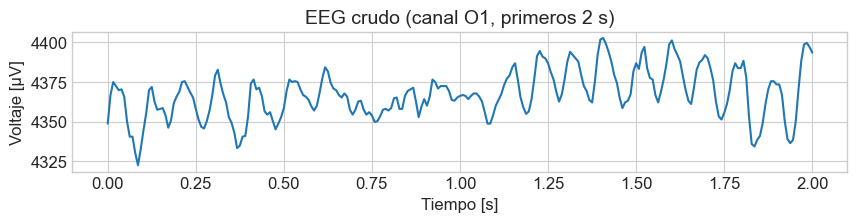

In [9]:
mask_eeg = (t_eeg >= 0) & (t_eeg <= 2)
plt.subplot(2,1,1)
plt.plot(t_eeg[mask_eeg], eeg_O1[mask_eeg])
plt.title("EEG crudo (canal O1, primeros 2 s)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [µV]")

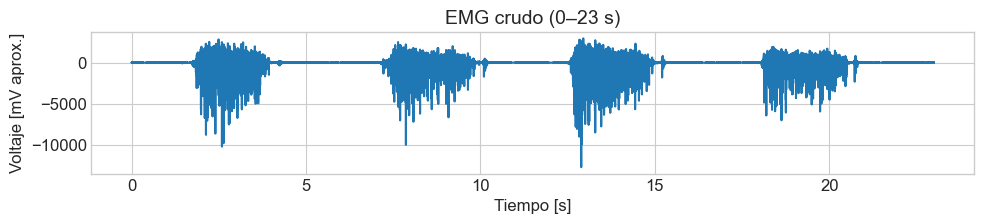

In [10]:
t0, tf = 0, 23
i0, i1 = int(t0*fs_emg), int(tf*fs_emg)
plt.subplot(2,1,2)
plt.plot(timeEMG[i0:i1], waveData[i0:i1])
plt.title("EMG crudo (0–23 s)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [mV aprox.]")

plt.tight_layout()
plt.show()

## 6.4 Filtrado Paso Banda

Aunque ambas señales requieren filtrado para mejorar la relación señal-ruido, los rangos de corte responden a objetivos distintos.

1.  **EEG (2–45 Hz):**
    * Se preservan los ritmos **Alfa (8-13 Hz)** y **Beta (14-30 Hz)**.
    * El corte superior a 45 Hz elimina el ruido muscular y la interferencia de línea eléctrica (50/60 Hz).
2.  **EMG (10–400 Hz):**
    * Se eliminan artefactos de movimiento de baja frecuencia (< 10 Hz).
    * Se conserva la banda ancha hasta 400 Hz donde reside la energía de los potenciales de acción muscular.

**1. Filtrado paso banda (10–400 Hz).**  
El EMG concentra la mayor parte de su energía en este rango de frecuencias. Los componentes por debajo de 10 Hz suelen provenir de artefactos de movimiento o del desplazamiento mecánico del electrodo, mientras que los que superan 400 Hz corresponden generalmente a ruido electrónico. El filtrado paso banda atenúa ambos extremos, conservando las descargas rápidas de fibras musculares superficiales. Al observar la señal tras este paso, se nota cómo desaparecen las oscilaciones lentas de la línea base, quedando un trazo más centrado en torno a cero y con picos más definidos.  

In [11]:
# Paso 1: Filtrado paso banda 10–400 Hz
nyq_emg = fs_emg / 2
b_emg, a_emg = butter(3, [10/nyq_emg, 400/nyq_emg], btype='band')
emg_filtered = filtfilt(b_emg, a_emg, waveData)

Text(0, 0.5, 'Voltaje [mV aprox.]')

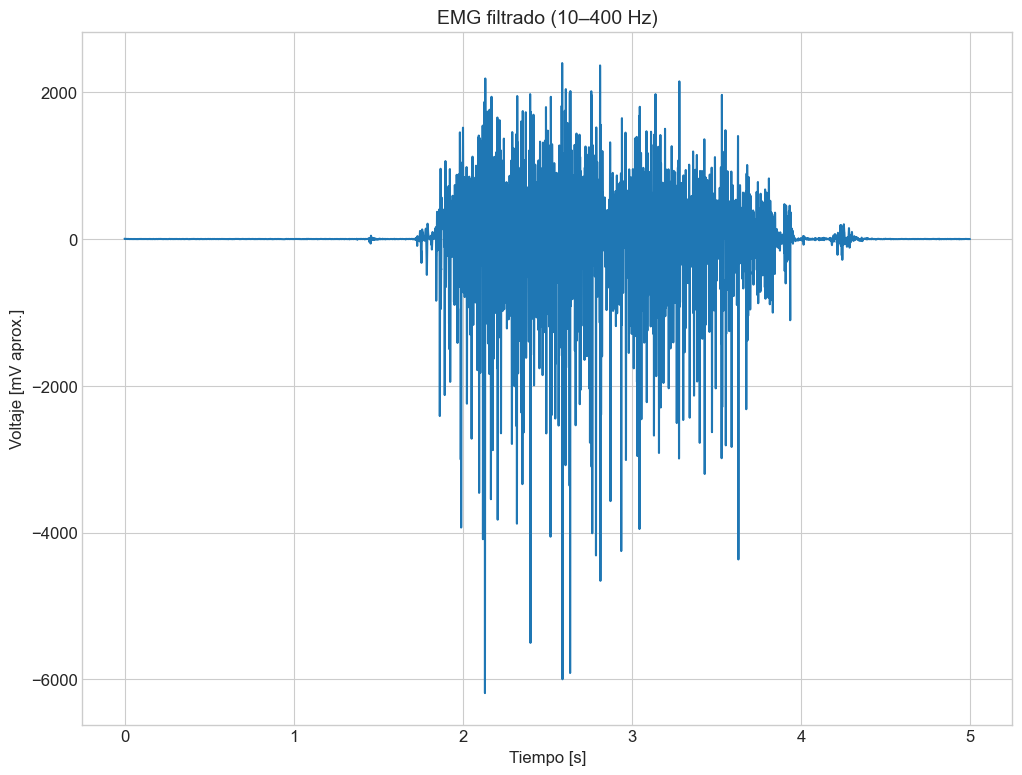

In [12]:
# Graficar pipeline EMG en primeros 5 s con paneles separados
mask_emg = (timeEMG >= 0) & (timeEMG <= 5)

plt.figure(figsize=(12,9))

# Filtrado
plt.plot(timeEMG[mask_emg], emg_filtered[mask_emg], color="tab:blue")
plt.title("EMG filtrado (10–400 Hz)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [mV aprox.]")

## 6.5 Procesamiento Posterior

La divergencia metodológica es crítica en esta etapa:

* **EEG (Análisis Espectral):** Buscamos caracterizar oscilaciones. **No se rectifica**, ya que la fase positiva/negativa es parte de la onda.
* **EMG (Rectificación y Envolvente):** La señal cruda es estocástica (suma de eventos aleatorios). Para cuantificar la "fuerza" o "activación", se debe **rectificar** (valor absoluto) y calcular la envolvente (RMS o filtro paso bajo).

##  Protocolo de procesamiento EMG

El electromiograma de superficie es un registro eléctrico altamente informativo, pero también muy vulnerable a artefactos. La señal cruda contiene tanto la actividad muscular como múltiples fuentes de ruido: movimiento de los electrodos, desplazamiento de la piel, interferencia de la red eléctrica e incluso ruido propio del amplificador. Por esta razón, no es posible interpretar directamente el trazo inicial. En su lugar, se aplica un **protocolo de procesamiento estandarizado** cuyo objetivo es aislar la actividad muscular real y representarla de manera clara.  

De acuerdo con Merletti y Hermens (2000), así como con De Luca (1997), este protocolo consta de tres pasos fundamentales:  

**1. Filtrado paso banda (10–400 Hz).**  
El EMG concentra la mayor parte de su energía en este rango de frecuencias. Los componentes por debajo de 10 Hz suelen provenir de artefactos de movimiento o del desplazamiento mecánico del electrodo, mientras que los que superan 400 Hz corresponden generalmente a ruido electrónico. El filtrado paso banda atenúa ambos extremos, conservando las descargas rápidas de fibras musculares superficiales. Al observar la señal tras este paso, se nota cómo desaparecen las oscilaciones lentas de la línea base, quedando un trazo más centrado en torno a cero y con picos más definidos.  

**2. Rectificación.**  
La señal EMG es alternante: oscila entre valores positivos y negativos en torno a cero. Esto significa que, si se calculara directamente una media, las descargas musculares tenderían a cancelarse entre sí. Para evitarlo, se aplica la rectificación, que consiste en tomar el valor absoluto de cada muestra. El resultado es un trazo únicamente positivo, en el que cada potencial de acción suma en la misma dirección. Esta operación tiene un sentido fisiológico claro: lo que interesa es la magnitud total de la contracción, no la polaridad de las descargas.  

**3. Cálculo de la envolvente.**  
Una vez rectificada, la señal puede suavizarse para representar de manera continua el nivel de activación muscular. La envolvente puede calcularse con un promedio móvil o con la transformada de Hilbert. Este último método ofrece una curva más estable y de la misma longitud que la señal original, lo que lo convierte en una opción robusta para visualizar la dinámica de la contracción. Al graficar la envolvente, se aprecia cómo los periodos de contracción destacan con claridad sobre el fondo, facilitando la identificación de fases activas e inactivas.  

En conjunto, este flujo de procesamiento —filtrado, rectificación y envolvente— convierte un registro ruidoso y oscilante en una representación que resume la fuerza y duración de la contracción muscular. Cada paso se justifica no solo desde el punto de vista técnico, sino también fisiológico, mostrando cómo los métodos digitales permiten dar forma cuantitativa a fenómenos biológicos.


Text(0, 0.5, 'Voltaje [mV aprox.]')

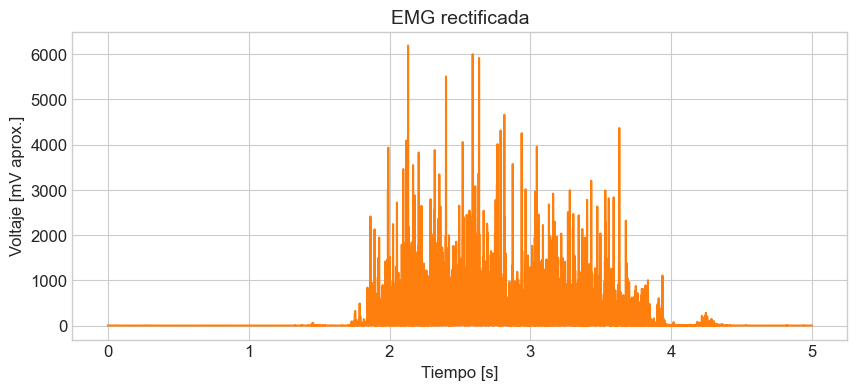

In [13]:
emg_rect = np.abs(emg_filtered)
plt.plot(timeEMG[mask_emg], emg_rect[mask_emg], color="tab:orange")
plt.title("EMG rectificada")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [mV aprox.]")

Text(0, 0.5, 'Voltaje [mV aprox.]')

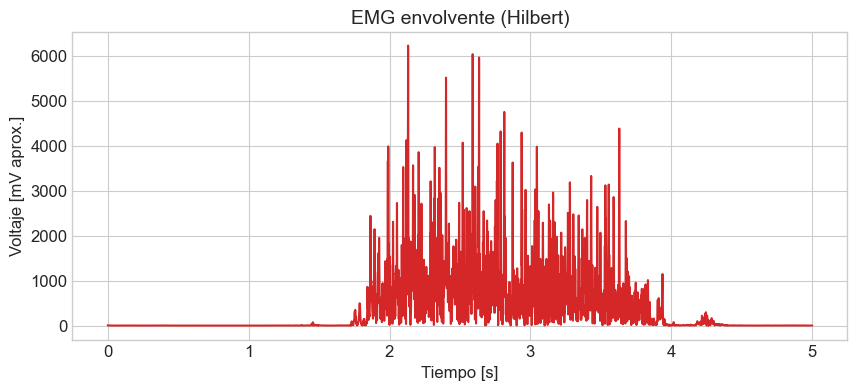

In [15]:
emg_env = np.abs(hilbert(emg_filtered))
plt.plot(timeEMG[mask_emg], emg_env[mask_emg], color="tab:red")
plt.title("EMG envolvente (Hilbert)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [mV aprox.]")

## 6.6 Métricas típicas


In [16]:
def validar_filtro(x, y):
    n = min(len(x), len(y))
    x, y = x[:n], y[:n]
    corr = np.corrcoef(x, y)[0,1] if np.std(x)>0 and np.std(y)>0 else 0.0
    pot = np.mean(y**2)
    residuo = x - y
    snr = 10*np.log10(np.sum(y**2)/np.sum(residuo**2)) if np.sum(residuo**2)>0 else np.inf
    return corr, pot, snr

corr, pot, snr = validar_filtro(waveData, emg_filtered)
print(f"Correlación: {corr:.3f}")
print(f"Potencia: {pot:.2f}")
print(f"SNR: {snr:.2f} dB")


Correlación: 0.891
Potencia: 227162.49
SNR: 4.73 dB


## 6.7 Interpretación
